## Exploration 9. Pneumonia Diagnosis Performance Improvement 🩺

### Checking the degree of model performance improvement by Mixing Methods

* The angle of the picture is randomly tilted by 30 degrees.
* Through the Histogram Equalization, the ratio was made 1:1 by combining the original image data and the image data subjected to agumentation.
* Control the learning speed through fine-tuning.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

### 2. Experiment Environment Set-up

### 2.1 Import Libraries

In [1]:
import os, re
import cv2
import random, math
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 2.2 Create Variable

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
HISTO_TRAIN_PATH = ROOT_PATH + '/histogram/data/train/*/*'
HISTO_VAL_PATH = ROOT_PATH + '/histogram/data/val/*/*'

TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


### 3. Load and View Data

### 3.1 Load Data

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
histo_train_filenames = tf.io.gfile.glob(HISTO_TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
histo_val_filenames = tf.io.gfile.glob(HISTO_VAL_PATH)

### 3.2 Data Explorations

### 3.2.1 Check the Number of Data

In [4]:
print('The number of train set :',len(train_filenames))
print('The number of histo_train set :',len(histo_train_filenames))
print('The number of test set :',len(test_filenames))
print('The number of validation set :',len(val_filenames))
print('The number of histo_validation set :',len(histo_val_filenames))

The number of train set : 5216
The number of histo_train set : 5216
The number of test set : 624
The number of validation set : 16
The number of histo_validation set : 16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다. 
# 원데이터 : augmentation이 진행된 데이터 = 1:1의 비율을 갖게된다.
filenames = tf.io.gfile.glob(TRAIN_PATH) + tf.io.gfile.glob(VAL_PATH) + tf.io.gfile.glob(HISTO_TRAIN_PATH) + tf.io.gfile.glob(HISTO_VAL_PATH)

                            
# 모아진 filenames를 8:2로 나눈다.      
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('The number of train set :',len(train_filenames))
print('The number of validation set :',len(val_filenames))

The number of train set : 8371
The number of validation set : 2093


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 2162
Pneumonia images count in training set: 6209


In [7]:
# tf.data 인스턴스 만들기
# tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# train data set 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

# validation data set 개수 확인
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 8371
Validating images count: 2093


In [9]:
# 현재 이미지에는 라벨 데이터가 따로 없는 상태
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함
# 이를 이용해 라벨 데이터를 만들어 주는 함수 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
# 이미지의 사이즈를 줄임과 동시에 통일시켜준다.

# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train data, validation data set 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# data 변환 여부 확인하기
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# test data set에도 위와 동일하게 적용
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# tf.data 파이프라인을 이용하여 prepare_for_training() 함수 정의
# shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
# repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 사용 가능
# batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
# prefetch() : 학습 데이터를 나눠서 읽어옴. 첫 번째 데이터가 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비. 리소스의 유휴 상태를 줄일 수 있음.

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


### 3.3 Data Visualization

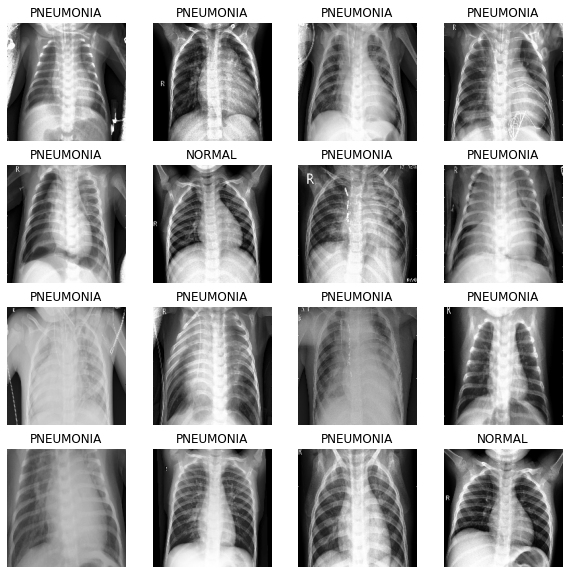

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. Create and Train a Model

### 4.1 CNN Modeling (Normalization, Dropout)

In [16]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)]),  # layer를 통해 이미지 회전
        
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 4.2 Data Imbalance Handling

In [19]:
# weight_for_0은 'Normal' 이미지에 사용할 weight 세팅
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight 세팅
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


### 4.3 Train a Model

In [20]:
# 미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss 사용
# optimizer로 'adam' 사용
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'사용

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# callback으로 훈련 중 가장 최상의 점수를 낸 모델 저장
# 매개변수 restore_best_weights를 True로 지정하여 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
cb = tf.keras.callbacks.ModelCheckpoint('mix_model.h5', save_best_only = True)

In [22]:
# 학습속도 조절
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[cb, es, lr_scheduler]
    )

Epoch 1/50
523/523 [==============================] - 124s 212ms/step - loss: 0.5261 - accuracy: 0.7421 - precision: 0.9022 - recall: 0.7316 - val_loss: 5.7725 - val_accuracy: 0.7317 - val_precision: 0.7423 - val_recall: 0.9807
Epoch 2/50
523/523 [==============================] - 98s 187ms/step - loss: 0.4043 - accuracy: 0.8207 - precision: 0.9365 - recall: 0.8134 - val_loss: 0.8066 - val_accuracy: 0.7663 - val_precision: 0.7643 - val_recall: 0.9923
Epoch 3/50
523/523 [==============================] - 95s 182ms/step - loss: 0.3619 - accuracy: 0.8400 - precision: 0.9474 - recall: 0.8304 - val_loss: 0.3209 - val_accuracy: 0.8644 - val_precision: 0.9482 - val_recall: 0.8647
Epoch 4/50
523/523 [==============================] - 99s 190ms/step - loss: 0.3162 - accuracy: 0.8621 - precision: 0.9585 - recall: 0.8510 - val_loss: 1.2205 - val_accuracy: 0.7442 - val_precision: 0.7446 - val_recall: 0.9994
Epoch 5/50
523/523 [==============================] - 101s 194ms/step - loss: 0.3099 - accu

### 4.4 Interpret the results

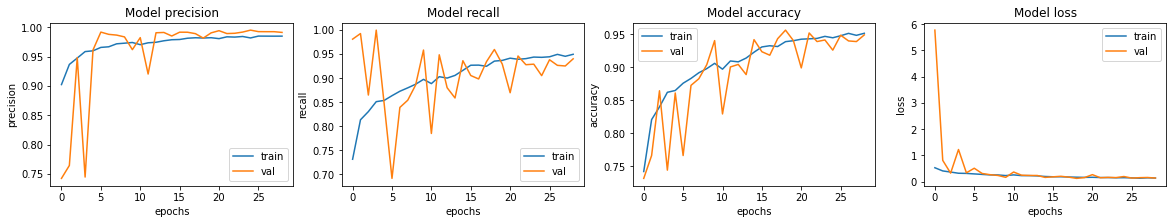

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5. Prediction Using Trained Model

In [25]:
best_model = keras.models.load_model('mix_model.h5')

In [26]:
loss, accuracy, precision, recall = best_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 111ms/step - loss: 0.4810 - accuracy: 0.7965 - precision: 0.7625 - recall: 0.9795
Loss: 0.48095887899398804,
Accuracy: 0.7964743375778198,
Precision: 0.7624750733375549,
Recall: 0.9794871807098389
